In [1]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



종이류, 금속캔, 유리병류, 플라스틱, 비닐 ,스티로폼

In [2]:
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

import os
import pandas as pd

base_path = "C:/Users/admin/Desktop/ImageFolder_Classification"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'glass', 2: 'metal', 3: 'vinyl', 4: 'plastic', 5: 'styrofoam',
              6: 'clothes', 7: 'pot', 8: 'lightbulb', 9: 'wood', 10: 'furniture',
              11: 'electronic'}

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(os.path.join(base_path, categories[category]))
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df['filename'] = df.apply(lambda x: categories[x['category']] + '/' + x['filename'], axis=1)

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))
print(df.head())


number of elements =  13537
                     filename  category
0         paper/paper_143.jpg         0
1            wood/wood_36.jpg         9
2         glass/glass_259.jpg         1
3           wood/wood_874.jpg         9
4  furniture/furniture_57.jpg        10


clothes
electronic
furniture
glass
lightbulb
metal
paper
plastic
pot
styrofoam
vinyl
wood

In [3]:
df

,filename,category
0,paper/paper_143.jpg,0
1,wood/wood_36.jpg,9
2,glass/glass_259.jpg,1
3,wood/wood_874.jpg,9
4,furniture/furniture_57.jpg,10
...,...,...
13532,plastic/plastic_7.jpg,4
13533,metal/metal_1227.jpg,2
13534,lightbulb/lightbulb_134.jpg,8
13535,wood/wood_54.jpg,9


In [4]:
!pip install tensorflow

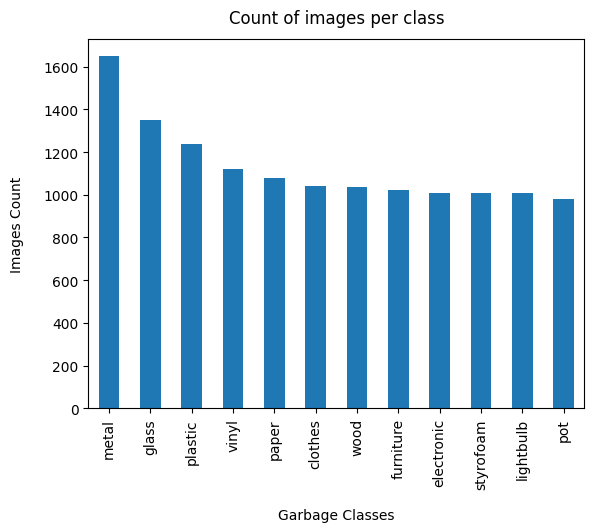

In [5]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

imagenet SSLCertVerificationError solved!!

In [5]:

import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context


Downloading the weights...

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.xception as xception

xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = 'imagenet')

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 12)                24588     
                                                                 
Total params: 20,886,068
Trainable params: 24,588
Non-trainable params: 20,861,480
_________________________________________________________________


In [16]:
early_stop = EarlyStopping(patience = 5, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


In [17]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  10829 validate size =  1354 test size =  1354


In [18]:
batch_size=32

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 10828 validated image filenames belonging to 12 classes.


c:\Users\admin\anaconda3\envs\dongwoo\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [19]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1354 validated image filenames belonging to 12 classes.


In [21]:
EPOCHS = 1
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\admin\AppData\Local\Temp\ipykernel_26852\565998745.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


338/338 [==============================] - 564s 2s/step - loss: 0.7730 - categorical_accuracy: 0.7531 - val_loss: 0.6569 - val_categorical_accuracy: 0.7812


In [22]:
model.save_weights("CLASS_12_MODEL.h5")

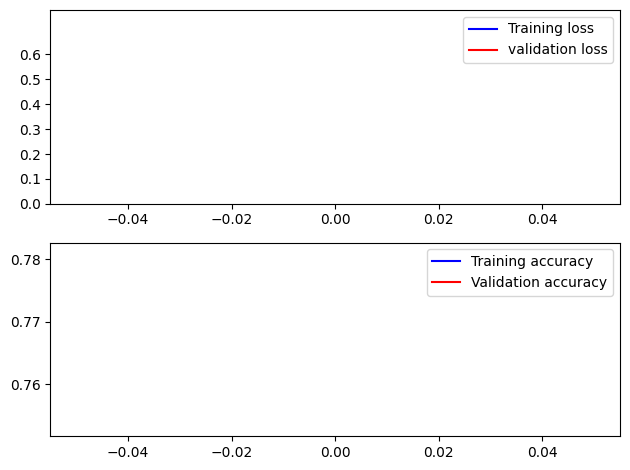

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [24]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1354 validated image filenames belonging to 12 classes.


In [26]:
filenames = test_generator.filenames
nb_samples = len(filenames)

print(nb_samples)

1354


In [27]:
_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

C:\Users\admin\AppData\Local\Temp\ipykernel_26852\3037518044.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


accuracy on test set =  77.62 % 


In [28]:
test_generator.class_indices

{'clothes': 0,
 'electronic': 1,
 'furniture': 2,
 'glass': 3,
 'lightbulb': 4,
 'metal': 5,
 'paper': 6,
 'plastic': 7,
 'pot': 8,
 'styrofoam': 9,
 'vinyl': 10,
 'wood': 11}

In [29]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'clothes', 1: 'electronic', 2: 'furniture', 3: 'glass', 4: 'lightbulb', 5: 'metal', 6: 'paper', 7: 'plastic', 8: 'pot', 9: 'styrofoam', 10: 'vinyl', 11: 'wood'}


In [30]:
nb_samples

1354

In [31]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()
#############dunno.....
print(classification_report(labels, preds))

C:\Users\admin\AppData\Local\Temp\ipykernel_26852\1168950881.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     clothes       0.92      0.97      0.94        91
  electronic       0.80      0.64      0.71       116
   furniture       0.79      0.77      0.78       104
       glass       0.80      0.78      0.79       141
   lightbulb       0.86      0.94      0.90       106
       metal       0.67      0.73      0.70       150
       paper       0.74      0.69      0.71       108
     plastic       0.69      0.72      0.70       121
         pot       0.85      0.65      0.74        95
   styrofoam       0.77      0.94      0.84       110
       vinyl       0.67      0.79      0.73       108
        wood       0.89      0.74      0.81       104

    accuracy                           0.78      1354
   macro avg       0.79      0.78      0.78      1354
weighted avg       0.78      0.78      0.77      1354



In [32]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

print(confusion_matrix(preds,labels))

[[ 88   0   1   0   0   0   2   0   0   0   3   2]
 [  0  74   4   0   1   3   1   2   6   1   0   0]
 [  0   4  80   1   0   4   3   1   1   0   2   5]
 [  0   2   0 110   3   7   1  14   0   0   0   0]
 [  0   2   0   2 100   4   0   1   2   0   0   5]
 [  0  10   3  10   1 110   3   3  11   3   3   6]
 [  0   3  10   0   0   4  75   0   1   3   4   2]
 [  0   6   2  17   0   4   0  87   6   0   5   0]
 [  0   1   0   0   1   2   2   5  62   0   0   0]
 [  0  11   2   0   0   4   3   1   2 103   6   2]
 [  3   2   0   1   0   5  17   6   2   0  85   5]
 [  0   1   2   0   0   3   1   1   2   0   0  77]]


In [33]:
#model save
model.save('C:/Users/admin/Desktop/ImageFolder_Recyclableness/CLASS_12_MODEL.h5')


In [34]:
keras.models.load_model('C:/Users/admin/Desktop/ImageFolder_Recyclableness/CLASS_12_MODEL.h5', custom_objects=None, compile=True)
